## Estudo de caso: detecção e classificação de sinalização de trânsito em imagens com Deep Learning

**Aluno:** Ráfagan Abreu <br/>
American Global Tech University <br/>
I11: Mestrado em Inteligência Artificial <br/>
**Professor:** João Carlos Lopes Fernandes <br/>
24/08/2025

## A. Introdução

### 1. Contexto do problema e relevância

A história dos veículos motorizados remonta ao final do século XIX (Britannica, 2025), quando a invenção do automóvel transformou radicalmente a forma como as pessoas se deslocavam. Inicialmente vistos como um avanço tecnológico voltado apenas para transporte individual, os automóveis rapidamente se tornaram parte essencial da sociedade moderna, impulsionando o crescimento econômico, a urbanização e a globalização. No entanto, essa expansão em larga escala trouxe também desafios significativos, tanto em aspectos ambientais — como a poluição sonora e atmosférica — quanto em logística e prevenção de acidentes. Foi nesse contexto que surgiram os primeiros sistemas de sinalização de trânsito, concebidos para organizar o fluxo de veículos, reduzir colisões e garantir maior segurança das vias.

A sinalização de trânsito desempenha um papel essencial na organização da mobilidade urbana, na redução de acidentes e na garantia da segurança de motoristas e pedestres. A sua origem remonta ao início do século XX, quando as primeiras placas de trânsito começaram a ser padronizadas na Europa. Em 1909, durante uma convenção internacional em Paris (UNECE, 2022), foram definidos os primeiros sinais oficiais — voltados principalmente para advertir sobre curvas, cruzamentos e passagens de nível. O Reino Unido também foi pioneiro com o uso de placas de limite de velocidade e semáforos manuais ainda no final do século XIX (Clark, 2019), enquanto os Estados Unidos rapidamente aderiram às inovações com o primeiro semáforo elétrico instalado em Cleveland, em 1914 (Cleveland Police Museum, 2023). Esses marcos demonstram a crescente preocupação das nações industrializadas em criar normas universais para garantir a segurança viária, consolidando a sinalização como elemento indispensável para o funcionamento das cidades modernas.

O processo de padronização global da sinalização ganhou força com a Convenção de Viena sobre Sinalização Rodoviária, realizada em 1968 sob a égide da ONU (UNECE, 1968). Esse acordo estabeleceu normas universais para formatos, cores e símbolos das placas, permitindo que motoristas de diferentes países interpretassem a sinalização de forma consistente. Atualmente, mais de 70 países seguem esse modelo, incluindo grande parte da Europa, América Latina, Ásia e África, e países como o Brasil e a Alemanha (Stallkamp, 2011).

No contexto dos veículos motorizados, surgem pesquisas acerca de veículos autônomos ou autodirigíveis (Zhao, 2025), os quais utilizam técnicas de Machine Learning e, em especial sua sub-área Deep Learning, visando desenvolver automóveis capazes de navegar em ambientes urbanos com mínima ou inexistente supervisão humana. Dentre os desafios existentes na produção desses agentes, temos o reconhecimento de sinalização de trânsito, sendo também um tema amplamente investigado por pesquisadores de visão computacional (Arcos-García, 2018) (Mogelmose, 2012) (Zhu, 2016).

### 2. Objetivos

Sendo assim, o objetivo deste trabalho é explorar técnicas de Deep Learning, como redes Multi-Layer Perceptron (MLP), Convolutional Neural Networks (CNN), Transfer Learning e Fine-Tuning, para detecção e classificação de sinalização de trânsito. Para tal, serão desenvolvidas Redes Neurais utilizando principalmente a tecnologia TensorFlow (Abadi, 2016) e Keras (Chollet, 2015), além de modelos de referência já treinados, como a família Efficient Net V2 (Tan, 2021) e o YOLO-Nano v11 (Wong, 2019), comparando-os com modelos autorais propostos. A base de dados utilizada para treinamento será a German Traffic Sign Recognition Benchmark (GTSRB) (Stallkamp, 2011), que é uma base muito popular de imagens de sinalização de trânsito na Alemanha, que segue o padrão mundial (UNICE, 1968). Pretende-se concluir com o estudo que Deep Learning é uma alternativa eficiente para classificação de sinalização de trânsito.

A organização do estudo de caso será dada da seguinte forma:

1. Metodologia:
* Preparação do ambiente: Quais são as tecnologias necessárias para a execução dos experimentos.
* Pré-processamento: Análise exploratória e apresentação dos dados.
* Arquitetura dos modelos autorais: Apresentação das abordagens de construção do modelo e treinamento utilizadas nas abordagens MLP e CNN
* Transfer learning: Apresentação das abordagens de construção do modelo e treinamento utilizadas nas abordagens de transfer learning e fine tuning com Efficient Net V2 e YOLO

2. Resultados e discussão:
* Comparação de desempenho dos modelos
* Discussão sobre overfitting

3. Conclusão:
* Avaliação da hipótese
* Trabalhos futuros

## B. Metodologia

### 1. Preparação do ambiente

Vamos instalar as dependências necessárias, bem como baixar a base de dados. Será utilizado o python 3.12:

In [ ]:
%%bash

# Instalação dependências

# Redes neurais
pip install tensorflow keras scikit-learn
# YOLO
pip install ultralytics
# Visão computacional
pip install opencv-python pillow
# Utils
pip install matplotlib numpy tqdm

In [ ]:
%%bash

# Download da base de dados
mkdir -p data
wget https://cdn.cs50.net/ai/2023/x/projects/5/gtsrb.zip -O data/gtsrb.zip
unzip -q data/gtsrb.zip -d data/
rm data/gtsrb.zip

Para o YOLO e Efficient Net V2, precisaremos de uma estrutura de arquivos um pouco diferente do dataset original:
* A estrutura de pastas precisa ser separada em bases de treino (train), validação (val) e teste (test)
* O dataset original possui imagens no formato PPM (Portable PixMap). Precisamos converter para JPG

In [ ]:
import random
from pathlib import Path
from PIL import Image
from tqdm import tqdm

SRC = Path('gtsrb')
DST = Path('gtsrb_yolo')
random.seed(42)

# 80% treino, 10% validação, 10% teste
splits = {'train': 0.8, 'val': 0.1, 'test': 0.1}
classes = sorted([d for d in SRC.iterdir() if d.is_dir()])

# cria pastas destino
for split in splits:
    for c in classes:
        (DST/split/c.name).mkdir(parents=True, exist_ok=True)

# pega todas as imagens primeiro
all_imgs = []
for c in classes:
    imgs = [p for p in c.iterdir() if p.suffix.lower() == '.ppm']
    random.shuffle(imgs)
    n = len(imgs)
    n_train = int(n * splits['train'])
    n_val   = int(n * splits['val'])
    parts = {
        'train': imgs[:n_train],
        'val':   imgs[n_train:n_train+n_val],
        'test':  imgs[n_train+n_val:],
    }
    for sp, files in parts.items():
        for f in files:
            all_imgs.append((f, DST/sp/c.name/f.with_suffix('.jpg').name))

# Conversão das imagens
for src, dst in tqdm(all_imgs, desc='Convertendo imagens', unit='img'):
    try:
        with Image.open(src) as im:
            im.convert('RGB').save(dst, 'JPEG')
    except Exception as e:
        print('Erro ao converter', src, e)

print('\nFeito! Estrutura pronta em', DST)

### 2. Pré-processamento

Observe que a base de dados GTSRB está dividida em 43 classes, separadas por pastas indexadas de 0 a 42. Portanto, trata-se de uma base rotulada e de um treinamento supervisionado.

O total de imagens é de 26640, e os tamanhos mais comuns variam de 30x30 a 38x38:

In [1]:
from pprint import pprint
import os
import cv2
from collections import Counter

def collect_sizes(base_dir):
    sizes = []
    for root, _, files in os.walk(base_dir):
        for f in files:
            if f.lower().endswith('.ppm'):
                path = os.path.join(root, f)
                img = cv2.imread(path)
                if img is not None:
                    h, w = img.shape[:2]
                    sizes.append((w, h))
    return sizes

sizes = collect_sizes('traffic/gtsrb')
print(f'Total de imagens: {len(sizes)}')

print(f'Tamanhos mais comuns:')
counter = Counter(sizes)
pprint(counter.most_common(10))


Total de imagens: 26640
Tamanhos mais comuns
[((30, 30), 256),
 ((31, 31), 254),
 ((32, 32), 250),
 ((35, 35), 247),
 ((38, 38), 246),
 ((29, 29), 245),
 ((36, 36), 234),
 ((30, 31), 228),
 ((34, 34), 228),
 ((33, 33), 225)]


As imagens possuem os mais diversos tamanhos variam em resolução, mas tendem a manter uma razão largura/altura próxima de 1:1, o que indica predominância de formatos quase quadrados, como se pode observar no gráfico a seguir:

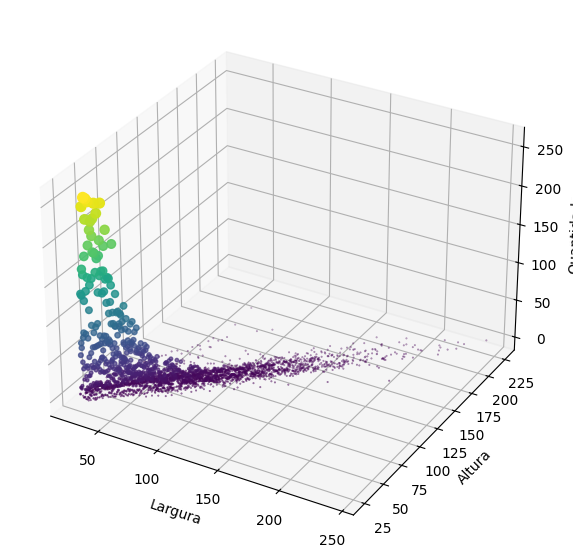

In [4]:
import matplotlib.pyplot as plt

xs = [w for (w, h), _ in counter.items()]
ys = [h for (w, h), _ in counter.items()]
zs = [count for _, count in counter.items()]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, c=zs, cmap='viridis', s=[z/5 for z in zs])

ax.set_xlabel('Largura')
ax.set_ylabel('Altura')
ax.set_zlabel('Quantidade')

plt.show()

Outra possível forma de visualização da distribuição de tamanhos é por meio de um gráfico de heatmap, onde os tamanhos mais comuns representam cores mais próximas do verde. Percebe-se que a maioria da base varia entre 25x25 e 50x50.

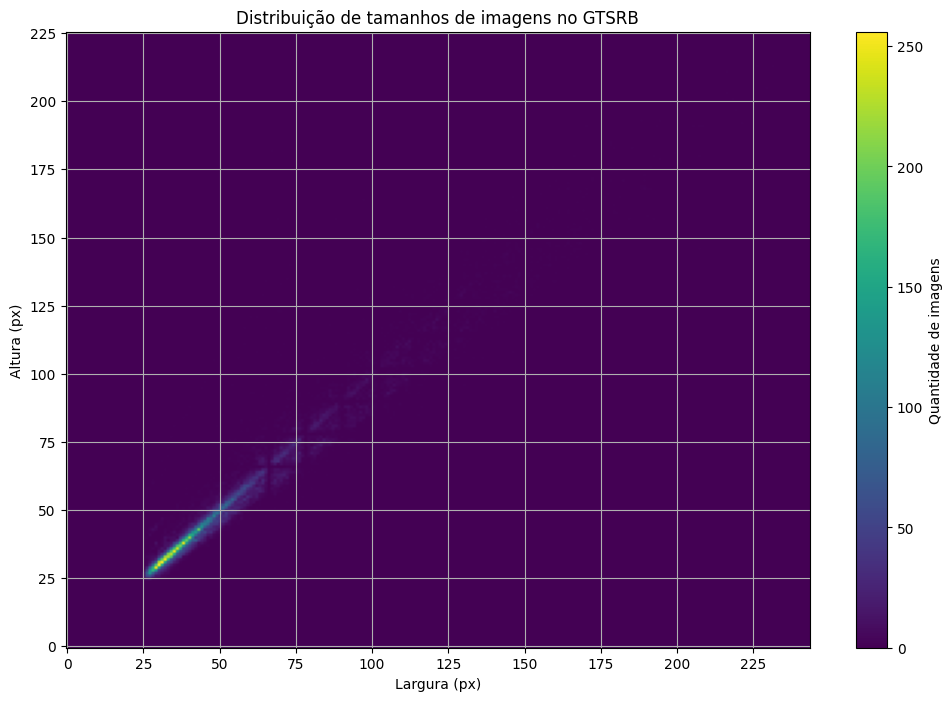

In [6]:
import matplotlib.pyplot as plt
import numpy as np

heatmap = {}
for (w, h), count in counter.items():
    heatmap[(w, h)] = count

max_w, max_h = max(xs), max(ys)
matrix = np.zeros((max_h+1, max_w+1))

for (w, h), count in counter.items():
    matrix[h, w] = count

plt.figure(figsize=(12, 8))
plt.imshow(matrix, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Quantidade de imagens')

plt.xlabel('Largura (px)')
plt.ylabel('Altura (px)')
plt.title('Distribuição de tamanhos de imagens no GTSRB')
plt.grid(True)

plt.xticks(range(0, matrix.shape[1], 25))
plt.yticks(range(0, matrix.shape[0], 25))

plt.show()

Feita a análise exploratória da base, vamos agora pré-processar os dados:
* Fazer a leitura das imagens, convertendo-as para tensores (largura, altura, canais)
* Garantir que todas as imagens estejam no espaço de cor RGB
* Redimensionamento (resizing) dos tensores para (32, 32, 3), sendo 32 um múltiplo de 2, de forma a garantir homogeneidade de tamanho, já que redes neurais não processam diretamente entradas com dimensões distintas. O algoritmo de resampling adotado foi o INTER_AREA, adequado para redução de imagens, conforme indicado pelo heatmap, que evidenciou a necessidade de reescalar a maioria das amostras para dimensões menores.
* Normalização dos valores de cor, uma vez que otimizadores de redes neurais, como ADAM e SGD, convergem mais facilmente quando os dados estão em escalas reduzidas e padronizadas.

In [11]:
import os
import cv2

NUM_CATEGORIES = 43
IMG_WIDTH = 32
IMG_HEIGHT = 32

def load_data(data_dir):
    images, labels = [], []
    for category in range(NUM_CATEGORIES):
        category_dir = os.path.join(data_dir, str(category))
        for file_path in os.listdir(category_dir):
            image = cv2.imread(str(os.path.join(category_dir, file_path)))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
            image = image.astype('float32') / 255.0
            images.append(image)
            labels.append(int(category))

    return images, labels

Uma outra possibilidade seria o carregamento sob demanda. Para isso, definimos o diretórios que serão datasources para cada base (treino, validação, teste), bem como regras de fetch e cache dos dados. É uma boa alternativa para bases de dados muito grandes e que já temos uma separação em disco dos datasets:

In [2]:
from tensorflow import keras
import tensorflow as tf


def load_data_lazy(data_dir, img_size, batch_size):
    def make_ds(split, shuffle, seed=None):
        ds = keras.utils.image_dataset_from_directory(
            f'{data_dir}/{split}',
            image_size=(img_size, img_size),
            batch_size=batch_size,
            label_mode='categorical',
            shuffle=shuffle,
            seed=seed,
            color_mode='rgb',
            interpolation='area'
        )

        class_names = ds.class_names

        # Cache + prefetch (overlap CPU <-> GPU)
        ds = ds.cache().prefetch(tf.data.AUTOTUNE)
        return ds, class_names

    train_ds, class_names = make_ds('train', shuffle=True,  seed=42)
    val_ds, _   = make_ds('val',   shuffle=False)
    test_ds, _  = make_ds('test',  shuffle=False)
    return train_ds, val_ds, test_ds, class_names

### 3. Arquitetura dos modelos autorais

Para classificar as imagens, utilizaremos Redes Neurais, a técnica central por trás do Deep Learning. Nesse modelo, cada neurônio (ou perceptron) recebe entradas da camada anterior e transmite sua saída para os neurônios da próxima camada. Essa comunicação é mediada por pesos, que indicam a importância de cada conexão. O valor de saída de um neurônio é calculado a partir de uma combinação linear dessas entradas ponderadas pelos pesos, podendo ainda passar por uma função de ativação, responsável por introduzir não linearidade e permitir que a rede aprenda padrões complexos. Durante o treinamento, a rede calcula o erro entre a predição e o valor real; esse erro é propagado para trás por meio do algoritmo de backpropagation, ajustando os pesos com base no gradiente do erro, geralmente mediante métodos como a descida de gradiente.

O modelo autoral a ser desenvolvido deve suprir às seguintes características:
* Trabalhar com categorias (43 classes);
* Executar 30 épocas de treinamento, utilizando mini-batches de 32 amostras — ou seja, a cada iteração os pesos da rede são atualizados com base na média do gradiente calculado sobre 32 exemplos;
* Dividir a base em:
 * 80% das amostras para treinamento;
 * 10% para validação das épocas: Para acompanhar overfitting durante o treinamento;
 * 10% para teste do resultado: Utilizada para avaliar se o modelo foi capaz de generalizar, calculando precisão em amostras desconhecidas.
* Estratificar os dados conforme as classes, garantindo que a divisão entre treino e teste preserve a proporção original de cada classe. Dessa forma, evita-se que alguma classe fique ausente ou sub-representada em um dos conjuntos;
* Receber como input um tensor (32, 32, 3) representando a imagem;
* Retornar como output um array de 43 valores, um para cada classe, representando a probabilidade de cada classe para uma dada imagem (softmax);
* Utilizar a função de perda `categorical crossentropy`, que mede a diferença entre a classe prevista pelo modelo (saída do `softmax`) e a classe real, penalizando previsões incorretas e incentivando o modelo a atribuir maior probabilidade à classe correta;
* Trabalhar as regularizações de forma a evitar overfitting:
  * Early Stopping: interromper o treinamento caso não haja melhoria na métrica de validação após 5 épocas consecutivas;
  * Reduce LR On Plateau: reduzir a taxa de aprendizado num fator pré-definido se a perda de validação permanecer estagnada por 3 épocas;
  * L2: definir uma constante `weight decay` para controlar o tamanho dos pesos da rede e evitar complexidade excessiva e memorização dos dados.
  * Dropout: desligar aleatoriamente alguns neurônios durante o treinamento, de modo que o modelo não dependa excessivamente de determinadas conexões, aprendendo representações mais robustas e generalizáveis.
* Monitorar as métricas de erro (loss), precisão (accuracy) e taxa de aprendizado (learning rate);
* Utilizar o otimizador Adam (Adaptive Moment Estimation), um dos otimizadores mais populares e eficazes em Deep Learning. Ele ajusta automaticamente a taxa de aprendizado de cada peso da rede, acelerando a convergência. Além disso, combina as vantagens do Momentum (suavizar oscilações ao acumular gradientes passados) e do RMSProp (ajustar a taxa de aprendizado conforme a frequência das atualizações). Na prática, isso torna o treinamento mais rápido e estável, funcionando bem em uma ampla variedade de problemas.

Segue algoritmo base para execução das ideias propostas:

In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
import numpy as np

VAL_SIZE = 0.1
TEST_SIZE = 0.1
EPOCHS = 30
BATCH_SIZE = 32

def gen_reduce_lr_on_plateau():
    return ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

def gen_early_stopping():
    return EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )

def run(model):
    # Pré-processa base de dados
    images, labels = load_data('./traffic/gtsrb')

    # Separa dados de treinamento e teste de forma estratificada
    labels = tf.keras.utils.to_categorical(labels)
    categories = np.array(labels)
    x_train, x_test, y_train, y_test = train_test_split(
        np.array(images), categories,
        test_size=TEST_SIZE,
        random_state=42,
        stratify=np.array(labels)
    )

    # Regularizações
    rlr = gen_reduce_lr_on_plateau()
    es = gen_early_stopping()

    # Treina o modelo com:
    # - Otimizador Adam: combina momentum e ajuste adaptativo da taxa de aprendizado
    # - Função de perda adequada para classificação multiclasse
    # - Regularização
    # - Mini batch
    # - Base de treino e validação
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VAL_SIZE,
        callbacks=[es, rlr]
    )

    print('\n Avaliação do modelo:')

    # Avaliação do modelo na base de teste
    model.evaluate(x_test, y_test, verbose=2)

    # Métricas (accuracy, recall, f1-score)
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(classification_report(y_true, y_pred_classes, digits=4))

    return history

#### a. MLP

O primeiro modelo produzido foi uma rede de Regressão Logística Softmax (LRS):
* Divide as classes apenas utilizando equações lineares dadas pelos pesos da rede e valores dos neurônios, ou seja, não possui mecanismos de não linearidade (como funções de ativação ReLU)
* Não extrai aprendizado da estrutura espacial da image

In [4]:
def gen_model_lrs():
    model = models.Sequential([
        layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        layers.Flatten(),
        layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])

    return model

history_model_lrs = run(model=gen_model_lrs())

Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5187 - loss: 2.0778 - val_accuracy: 0.6852 - val_loss: 1.4400 - learning_rate: 0.0010
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7452 - loss: 1.1892 - val_accuracy: 0.7640 - val_loss: 1.0792 - learning_rate: 0.0010
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8196 - loss: 0.9039 - val_accuracy: 0.8399 - val_loss: 0.8331 - learning_rate: 0.0010
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8485 - loss: 0.7466 - val_accuracy: 0.8253 - val_loss: 0.7609 - learning_rate: 0.0010
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8714 - loss: 0.6399 - val_accuracy: 0.8732 - val_loss: 0.6318 - learning_rate: 0.0010
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8837 - loss: 0.5774 - val_accuracy: 0.8686 - val_loss: 0.6088 - learning_rate: 0.0010
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8958 - loss: 0.5121 - 

O segundo modelo é um MLP de 5 camadas profundas com função de ativação ReLU, permitindo capturar padrões não lineares nos dados, mas ainda com restrições espaciais.

Foram realizados testes com diversas heurísticas de tamanhos de redes e quantidades de neurônios e esta foi a melhor solução encontrada:

In [12]:
def gen_model_mlp():
    model = models.Sequential([
        layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])

    return model

history_model_mlp = run(model=gen_model_mlp())

Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3137 - loss: 2.3547 - val_accuracy: 0.5250 - val_loss: 1.4842 - learning_rate: 0.0010
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6256 - loss: 1.1592 - val_accuracy: 0.7018 - val_loss: 0.9110 - learning_rate: 0.0010
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7518 - loss: 0.7637 - val_accuracy: 0.7652 - val_loss: 0.7212 - learning_rate: 0.0010
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8177 - loss: 0.5723 - val_accuracy: 0.7982 - val_loss: 0.6090 - learning_rate: 0.0010
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8572 - loss: 0.4547 - val_accuracy: 0.8061 - val_loss: 0.6366 - learning_rate: 0.0010
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8705 - loss: 0.4067 - val_accuracy: 0.8086 - val_loss: 0.6225 - learning_rate: 0.0010
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8851 - loss: 0.3660 - 

O terceiro modelo é o MLP anterior com regularização Dropout, uma das melhores técnicas para evitar overfitting. A escolha dos layers de Dropout e o percentual também foi resultado de diversas experimentações:

In [11]:
from tensorflow.keras.layers import Dropout


def gen_model_mlp_dropout():
    model = models.Sequential([
        layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])

    return model

history_model_mlp_dropout = run(model=gen_model_mlp_dropout())

Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2084 - loss: 2.7600 - val_accuracy: 0.3832 - val_loss: 1.9198 - learning_rate: 0.0010
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4347 - loss: 1.7512 - val_accuracy: 0.5234 - val_loss: 1.4167 - learning_rate: 0.0010
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5545 - loss: 1.3328 - val_accuracy: 0.6188 - val_loss: 1.1214 - learning_rate: 0.0010
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6378 - loss: 1.0965 - val_accuracy: 0.6272 - val_loss: 1.1703 - learning_rate: 0.0010
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7011 - loss: 0.9114 - val_accuracy: 0.7285 - val_loss: 0.8188 - learning_rate: 0.0010
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7321 - loss: 0.8225 - val_accuracy: 0.7698 - val_loss: 0.7194 - learning_rate: 0.0010
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7738 - loss: 0.7038 - 

#### b. CNN

O principal problema dos modelos MLP apresentados anteriormente é que eles não conseguem aproveitar a estrutura espacial da imagem. Isso acontece porque, logo após a camada de entrada, o tensor tridimensional (largura × altura × canais de cor) é convertido num vetor linear por meio da camada Flatten. Nesse processo, perde-se completamente a noção de vizinhança entre os pixels.

Já as Convolutional Neural Networks (CNNs) foram desenvolvidas justamente para lidar com esse tipo de dado. Em vez de transformar a imagem num vetor plano, elas mantêm a estrutura espacial e aplicam camadas de convolução (Conv2D). Essas camadas realizam operações matemáticas de convolução, muito conhecidas na área de processamento de imagens, sobre pequenas janelas da imagem (como 3×3 ou 5×5 pixels), permitindo a extração de padrões locais. Esses filtros podem aprender automaticamente a identificar características como:
* Bordas horizontais e verticais;
* Curvas e texturas;
* Formas mais complexas, como números, símbolos e objetos.

Após as convoluções, é comum utilizar a camada MaxPooling2D, cujo objetivo é reduzir a dimensionalidade da representação gerada sem perder informações relevantes. Essa camada percorre a imagem com pequenas janelas (geralmente 2x2) e mantém apenas o valor máximo em cada região, descartando os demais. Isso traz benefícios importantes: diminui o número de parâmetros, reduz o custo computacional, evita overfitting e aumenta a robustez da rede contra variações de posição ou pequenas distorções nas imagens.

A vantagem de diminuir a dimensionalidade é que, após os filtros de convolução, muitos dados irrelevantes já foram descartados. Assim, o pooling permite compactar ainda mais a imagem para a próxima camada, tornando o aprendizado mais eficiente e ajudando a rede a generalizar melhor para novos padrões.

A CNN desenvolvida segue logo abaixo. A inspiração foi a arquitetura CNN descrita em (Arcos-García, 2018), e basicamente segue arquiteturas clássicas de redes CNN, como a VGG-Net. Observe também a aplicação da regularização L2 e Dropout para evitar overfitting. Note também que ao final da CNN temos um MLP que traduz as descobertas dos filtros em probabilidades para cada classe:

In [5]:
from tensorflow.keras import regularizers


def gen_model_cnn():
    weight_decay = 1e-4

    model = models.Sequential([
        layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),

        # Camada 1: bordas
        # Arquiteturas VGG inspiradas usam 2 camadas de convolução seguidas
        layers.Conv2D(
            32, (3, 3),
            activation='relu', padding='same',
            kernel_regularizer=regularizers.l2(weight_decay)
        ),
        layers.Conv2D(
            32, (3, 3),
            activation='relu', padding='same',
            kernel_regularizer=regularizers.l2(weight_decay)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),  # Redução de dimensionalidade
        layers.Dropout(0.25),

        # Camada 2: curvas e texturas
        # 32 → 64 filtros: Camadas mais profundas capturam padrões mais complexos
        layers.Conv2D(
            64, (3, 3),
            activation='relu', padding='same',
            kernel_regularizer=regularizers.l2(weight_decay)
        ),
        layers.Conv2D(
            64, (3, 3),
            activation='relu', padding='same',
            kernel_regularizer=regularizers.l2(weight_decay)
        ),
        layers.BatchNormalization(),  # Valores normalizados estabilizam o gradiente
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Layer MLP de Classificação
        layers.GlobalAveragePooling2D(),  # Mais eficiente que Flatten para CNNs
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])

    return model

history_model_cnn = run(model=gen_model_cnn())

Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.2280 - loss: 2.6939 - val_accuracy: 0.3874 - val_loss: 2.0932 - learning_rate: 0.0010
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5565 - loss: 1.3874 - val_accuracy: 0.6914 - val_loss: 0.9914 - learning_rate: 0.0010
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8057 - loss: 0.6394 - val_accuracy: 0.9120 - val_loss: 0.3010 - learning_rate: 0.0010
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.9112 - loss: 0.3334 - val_accuracy: 0.9783 - val_loss: 0.1436 - learning_rate: 0.0010
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.9398 - loss: 0.2417 - val_accuracy: 0.9746 - val_loss: 0.1264 - learning_rate: 0.0010
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.9589 - loss: 0.1855 - val_accuracy: 0.9754 - val_loss: 0.1268 - learning_rate: 0.0010
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.9674 - l

### 4. Transfer learning

Apresentadas algumas estratégias autorais com MLP e CNN, o próximo passo é trabalhar com redes neurais já existentes, adaptando-as ao problema proposto. Essa técnica é chamada de Transfer Learning. A ideia básica consiste em reaproveitar um modelo pré-treinado em um grande conjunto de dados (como o ImageNet) e ajustar apenas sua parte final. Na prática, isso significa substituir a camada de saída original — que no EfficientNetV2 prevê 1000 classes — por uma nova camada adaptada às 43 classes do GTSRB.

Uma alternativa mais avançada é adicionar novas camadas ao final da rede e realizar o fine-tuning, descongelando parte das últimas camadas convolucionais. Isso permite que a rede ajuste suas features de alto nível às particularidades do novo domínio. Essa abordagem costuma trazer melhor generalização e convergir mais rápido do que treinar uma CNN do zero, além de economizar tempo e recursos computacionais ao aproveitar o conhecimento já adquirido em treinamentos prévios.

#### a. Efficient Net V2

O Efficient Net V2 (Tan, 2021) é uma evolução da família EfficientNet, projetada para melhorar tanto a precisão quanto a eficiência no treinamento de redes convolucionais. Assim como outras arquiteturas modernas, foi originalmente treinado no ImageNet, um dos maiores e mais importantes conjuntos de dados de visão computacional, que serve como base para modelos de classificação de imagens em diversos domínios. Em relação à primeira versão, o EfficientNetV2 introduz camadas mais rápidas (fused-MBConv) e técnicas avançadas de regularização, resultando em treinamento mais ágil e melhor capacidade de generalização, tornando-o especialmente adequado para tarefas de transfer learning como a classificação de sinalização de trânsito.

A primeira etapa para aplicar o Transfer Learning é adicionar um novo layer de output e treinar o modelo nessa rede. A Efficient Net V2 foi treinada em imagens 224x224, então teremos que utilizar esse tamanho ao invés de 32x32. Treinaremos essa camada com 1/3 das épocas.


In [3]:
from tensorflow.keras import layers, optimizers, callbacks
from keras.src.applications.efficientnet_v2 import preprocess_input, EfficientNetV2B0

# EfficientNet usam 224x224 por padrão
IMG_SIZE = 224

def do_efficient_net_transfer_learning(train_ds, val_ds, class_names):
    # Download da rede, exceto a última camada
    base = EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # congela o backbone
    base.trainable = False

    # Insere os inputs do nosso dataset
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = preprocess_input(inputs)
    x = base(x, training=False)

    # Cria uma nova camada de output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)

    # Regularizações
    rlr = gen_reduce_lr_on_plateau()
    es = gen_early_stopping()

    # Treina o modelo com 1/3 das épocas
    model = keras.Model(inputs, outputs, name='gtsrb_efficientnet')
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS // 3,
        callbacks=[es, rlr],
    )

    return base, model

A próxima etapa é realizar o fine-tuning. Vamos retreinar as últimas 30 camadas da rede (a Efficient Net possui mais de 80, isso no modelo mais simples – B0). No treinamento inicial usamos uma taxa de aprendizado maior (0.001), e no fine-tuning reduzimos para 0.0001 para evitar ajustes bruscos nos pesos já aprendidos. Aqui rodamos as demais 2/3 épocas:

In [4]:
def do_efficient_net_fine_tuning(base, model, train_ds, val_ds, test_ds):
    # Destrava parcialmente (por ex. últimas 30 camadas)
    base.trainable = True
    for layer in base.layers[:-30]:
        layer.trainable = False

    # Regularizações
    rlr = gen_reduce_lr_on_plateau()
    es = gen_early_stopping()

    # Treinamento
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # LR menor no FT
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS // 3 * 2,
        callbacks=[es, rlr]
    )

    print('\n Avaliação do modelo:')

    # Avaliação do modelo na base de teste
    model.evaluate(test_ds, verbose=2)

    # Métricas (accuracy, recall, f1-score)
    y_true = []
    for _, y in test_ds:
        y_true.append(np.argmax(y.numpy(), axis=1))
    y_true = np.concatenate(y_true, axis=0)

    y_pred_probs = model.predict(test_ds, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print(classification_report(y_true, y_pred, digits=4))

    return history

In [5]:
def run():
    train_ds, val_ds, test_ds, class_names = load_data_lazy('./traffic/gtsrb_yolo', IMG_SIZE, BATCH_SIZE)
    base, model = do_efficient_net_transfer_learning(train_ds, val_ds, class_names)
    return do_efficient_net_fine_tuning(base, model, train_ds, val_ds, test_ds)

history_model_efficient_net = run()

666/666 ━━━━━━━━━━━━━━━━━━━━ 252s 378ms/step - accuracy: 0.9705 - loss: 0.1019 - val_accuracy: 0.9775 - val_loss: 0.0716 - learning_rate: 1.0000e-04
Epoch 8/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 251s 377ms/step - accuracy: 0.9760 - loss: 0.0870 - val_accuracy: 0.9805 - val_loss: 0.0674 - learning_rate: 1.0000e-04
Epoch 9/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 224s 337ms/step - accuracy: 0.9793 - loss: 0.0771 - val_accuracy: 0.9805 - val_loss: 0.0605 - learning_rate: 1.0000e-04
Epoch 10/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 213s 319ms/step - accuracy: 0.9816 - loss: 0.0682 - val_accuracy: 0.9812 - val_loss: 0.0590 - learning_rate: 1.0000e-04
Epoch 11/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 213s 319ms/step - accuracy: 0.9819 - loss: 0.0635 - val_accuracy: 0.9816 - val_loss: 0.0557 - learning_rate: 1.0000e-04
Epoch 12/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 216s 324ms/step - accuracy: 0.9849 - loss: 0.0563 - val_accuracy: 0.9857 - val_loss: 0.0523 - learning_rate: 1.0000e-04
Epoch 13/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 221s 33

2025-08-25 01:19:23.682288: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

           0     1.0000    0.9333    0.9655        15
           1     0.9865    0.9733    0.9799       150
           2     1.0000    0.9926    0.9963       135
           3     1.0000    1.0000    1.0000        90
           4     1.0000    1.0000    1.0000       141
           5     1.0000    1.0000    1.0000       144
           6     1.0000    1.0000    1.0000        54
           7     1.0000    1.0000    1.0000        42
           8     1.0000    1.0000    1.0000        30
           9     1.0000    1.0000    1.0000        75
          10     1.0000    1.0000    1.0000        81
          11     1.0000    1.0000    1.0000        15
          12     0.9536    0.9600    0.9568       150
          13     1.0000    0.9583    0.9787        24
          14     1.0000    1.0000    1.0000        24
          15     1.0000    1.0000    1.0000        27
          16     0.9474    1.0000    0.9730        36
          17     1.0000    

### b. YOLO

Outro modelo muito popular para classificação de objetos em imagens e vídeos é o YOLO (Wong, 2019). O YOLO (You Only Look Once) é uma arquitetura originalmente projetada para detecção de objetos em tempo real, conhecida por sua velocidade e eficiência.

Diferentemente de modelos voltados exclusivamente para classificação, o YOLO analisa a imagem inteira de uma só vez e aprende a identificar múltiplos objetos simultaneamente. Ao longo de suas versões, a família YOLO evoluiu para incluir variações específicas também para classificação de imagens, como o YOLOv11n-cls, que herda a mesma filosofia de desempenho rápido, mas adaptada ao cenário de classificação pura.

O YOLO já vem com a possibilidade de executar transfer learning em sua própria biblioteca, facilitando o processo. Ele inclusive gera os relatórios de treinamento junto com o arquivo do modelo. Primeiro realizamos o treinamento com o nosso dataset organizado pelos rótulos:

In [12]:
from ultralytics import YOLO

model = YOLO('yolo11n-cls.pt')
model.train(
    data='./traffic/gtsrb_yolo',
    imgsz=IMG_WIDTH,
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    patience=5,
    optimizer='Adam',
    lr0=1e-3,
    device='mps'
)

New https://pypi.org/project/ultralytics/8.3.185 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0 MPS (Apple M1 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./traffic/gtsrb_yolo, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=32, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, o

train: Scanning /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/traffic/gtsrb_yolo/train... 21312 images, 0 corrupt: 100%|██████████| 21312/21312 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 12.4±6.7 MB/s, size: 1.6 KB)



val: Scanning /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/traffic/gtsrb_yolo/val... 2664 images, 0 corrupt: 100%|██████████| 2664/2664 [00:00<?, ?it/s]

optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 32 train, 32 val
Using 0 dataloader workers
Logging results to /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/runs/classify/train
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 25.14it/s]

                   all      0.602      0.914



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.65it/s]

                   all      0.765      0.978



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.47it/s]

                   all      0.824      0.982



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:00<00:00, 46.34it/s]

                   all      0.839      0.986



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:00<00:00, 45.75it/s]

                   all      0.886      0.993



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 37.74it/s]

                   all      0.895      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 33.00it/s]

                   all      0.903      0.996



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 33.67it/s]

                   all      0.925      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 33.71it/s]

                   all      0.924      0.998



      Epoch    GPU_mem       loss  Instances       Size


      10/30     0.119G     0.6708         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.66it/s]

                   all      0.937      0.998



      Epoch    GPU_mem       loss  Instances       Size


      11/30     0.119G     0.6358         32         32: 100%|██████████| 666/666 [00:41<00:00, 15.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 33.86it/s]

                   all      0.949      0.998



      Epoch    GPU_mem       loss  Instances       Size


      12/30     0.119G     0.5968         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.24it/s]

                   all      0.947      0.998



      Epoch    GPU_mem       loss  Instances       Size


      13/30     0.119G     0.5902         32         32: 100%|██████████| 666/666 [00:40<00:00, 16.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 33.97it/s]

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


      14/30     0.119G     0.5717         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 33.35it/s]

                   all      0.953      0.999



      Epoch    GPU_mem       loss  Instances       Size


      15/30     0.119G     0.5505         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.49it/s]

                   all      0.957      0.998



      Epoch    GPU_mem       loss  Instances       Size


      16/30     0.119G     0.5204         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.33it/s]

                   all      0.964          1



      Epoch    GPU_mem       loss  Instances       Size


      17/30     0.119G     0.5128         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 33.84it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


      18/30     0.119G     0.4933         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.10it/s]

                   all      0.972      0.999



      Epoch    GPU_mem       loss  Instances       Size


      19/30     0.119G     0.4739         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 33.84it/s]

                   all      0.971      0.999



      Epoch    GPU_mem       loss  Instances       Size


      20/30     0.119G     0.4724         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 32.68it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


      21/30     0.119G     0.4543         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.49it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      22/30     0.126G     0.4288         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.26it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


      23/30     0.119G     0.4224         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.20it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


      24/30     0.119G     0.4061         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 33.95it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


      25/30     0.119G     0.3909         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.73it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


      26/30     0.119G     0.3875         32         32: 100%|██████████| 666/666 [00:39<00:00, 16.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.45it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      27/30     0.119G     0.3652         32         32: 100%|██████████| 666/666 [00:40<00:00, 16.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.08it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      28/30     0.119G     0.3631         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.23it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


      29/30     0.119G     0.3573         32         32: 100%|██████████| 666/666 [00:41<00:00, 16.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.69it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


      30/30     0.119G     0.3379         32         32: 100%|██████████| 666/666 [00:40<00:00, 16.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:01<00:00, 34.13it/s]

                   all      0.984          1



30 epochs completed in 0.362 hours.
Optimizer stripped from /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/runs/classify/train/weights/last.pt, 3.3MB
Optimizer stripped from /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/runs/classify/train/weights/best.pt, 3.3MB

Validating /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/runs/classify/train/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0 MPS (Apple M1 Pro)
YOLO11n-cls summary (fused): 47 layers, 1,581,107 parameters, 0 gradients, 3.2 GFLOPs
train: /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/traffic/gtsrb_yolo/train... found 21312 images in 43 classes ✅ 
val: /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/traffic/gtsrb_yolo/val... found 2664 images in 43 classes ✅ 
test: /Users/rafagan/Library/Application Suppor

               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:00<00:00, 42.30it/s]


                   all      0.985          1
Speed: 0.0ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x308e97b00>
curves: []
curves_results: []
fitness: 0.992304801940918
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9846096038818359, 'metrics/accuracy_top5': 1.0, 'fitness': 0.992304801940918}
save_dir: PosixPath('/Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/runs/classify/train')
speed: {'preprocess': 0.008416540968628997, 'inference': 0.1328540412679751, 'loss': 5.803985504416732e-06, 'postprocess': 1.5625697994106883e-05}
task: 'classify'
top1: 0.9846096038818359
top5: 1.0

Depois utilizamos as imagens de teste para verificar a qualidade do modelo:

In [13]:
from pathlib import Path
from ultralytics import YOLO

model = YOLO('runs/classify/train/weights/best.pt')
model.val(data='./traffic/gtsrb_yolo')

def evaluate_yolo_model():
    files = sorted(str(p) for p in Path('./traffic/gtsrb_yolo/test').rglob('*.jpg'))

    y_true = [int(Path(f).parent.name) for f in files]

    results = model.predict(source=files, imgsz=IMG_WIDTH, batch=BATCH_SIZE, verbose=False)
    idx2name = model.names  # ex.: {0:'0', 1:'1', ..., 42:'42'}
    y_pred = [int(idx2name[int(r.probs.top1)]) for r in results]

    assert len(y_true) == len(y_pred), (len(y_true), len(y_pred))

    print(classification_report(y_true, y_pred, digits=4))

evaluate_yolo_model()

Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0 CPU (Apple M1 Pro)
YOLO11n-cls summary (fused): 47 layers, 1,581,107 parameters, 0 gradients, 3.2 GFLOPs
train: /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/traffic/gtsrb_yolo/train... found 21312 images in 43 classes ✅ 
val: /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/traffic/gtsrb_yolo/val... found 2664 images in 43 classes ✅ 
test: /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/traffic/gtsrb_yolo/test... found 2664 images in 43 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 96.9±32.9 MB/s, size: 1.6 KB)


val: Scanning /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/traffic/gtsrb_yolo/val... 2664 images, 0 corrupt: 100%|██████████| 2664/2664 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 167/167 [00:10<00:00, 15.76it/s]


                   all      0.985          1
Speed: 0.0ms preprocess, 3.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.2/projects/workspace/runs/classify/val
WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        15
           1     0.9799    0.9733    0.9766       150
           2     0.9673    0.9867    0.9769 

## C. Resultados e discussão

As métricas dos resultados de treinamento para cada modelo em um dado treinamento pode ser vistas na tabela abaixo (macro avg):

| Métrica/Modelo |   LRS   |   MLP   | MLP-Dropout |   CNN   | EfficientNet |   YOLO   |
|----------------|---------|---------|-------------|---------|--------------|----------|
| Accuracy       | 0.9459  | 0.9336  | 0.9557      | 0.9962  | 0.9895       | 0.9797   |
| Recall         | 0.9459  | 0.9336  | 0.9557      | 0.9962  | 0.9896       | 0.9797   |
| F1-score       | 0.9464  | 0.9342  | 0.9555      | 0.9962  | 0.9904       | 0.9797   |

O gráfico do treinamento para cada modelo pode ser visto abaixo. Pode-se observar que o CNN possui o melhor resultado. o YOLO poderia aumentar os resultados rodando em mais de 30 épocas, por se tratar de um modelo muito grande. O mesmo poderia acontecer com o Efficient Net. Mesmo assim, isso demonstra que dependendo do tipo de problema, soluções mais simples podem ser o suficiente.

Comparando o CNN com as abordagens MLP, percebe-se que todas as MLP alcançam overfitting em algum momento (quando o modelo erra mais os dados de validação do que acerta os de treinamento). Ou seja, mesmo alcançando valores altos de acerto durante o treinamento, na fase de teste e validação o modelo não supera a marca de 96% de acurácia, em se comparando com os quase 100% de acurácia do CNN.

In [6]:
import matplotlib.pyplot as plt

def plot_training_accuracy(history):
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.show()


def plot_training_loss(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

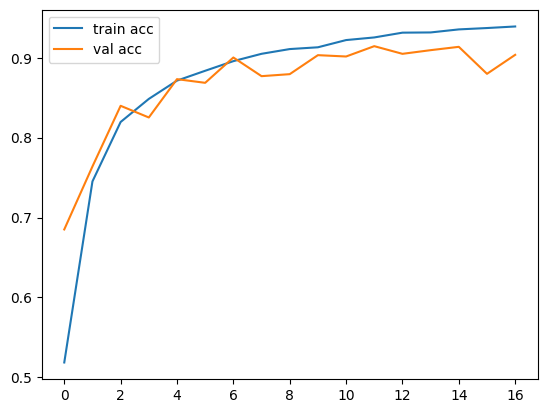

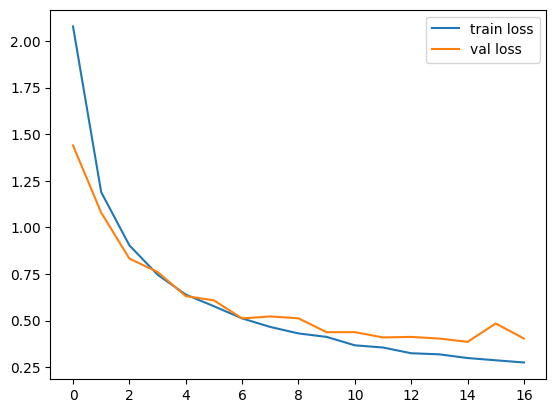

In [6]:
# LRS
plot_training_accuracy(history_model_lrs)
plot_training_loss(history_model_lrs)

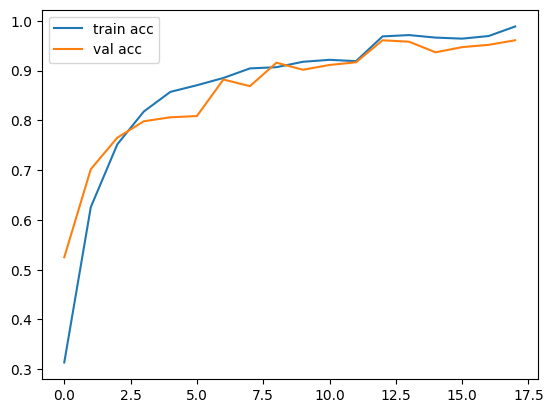

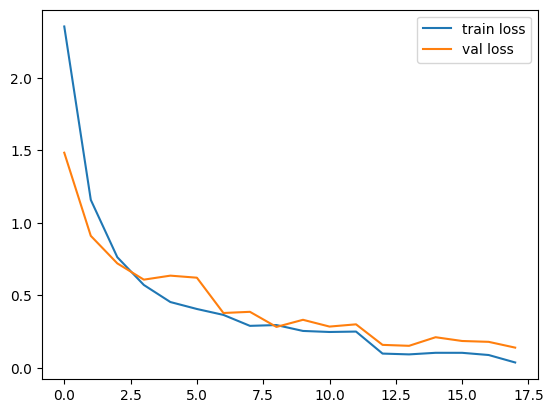

In [14]:
# MLP
plot_training_accuracy(history_model_mlp)
plot_training_loss(history_model_mlp)

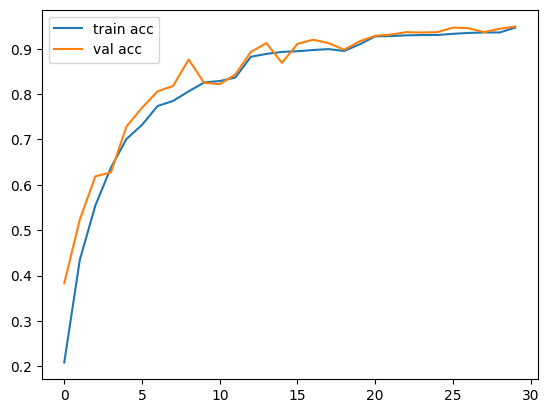

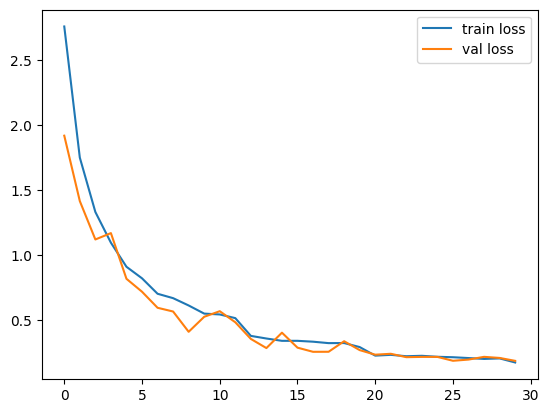

In [13]:
# MLP-Dropout
plot_training_accuracy(history_model_mlp_dropout)
plot_training_loss(history_model_mlp_dropout)

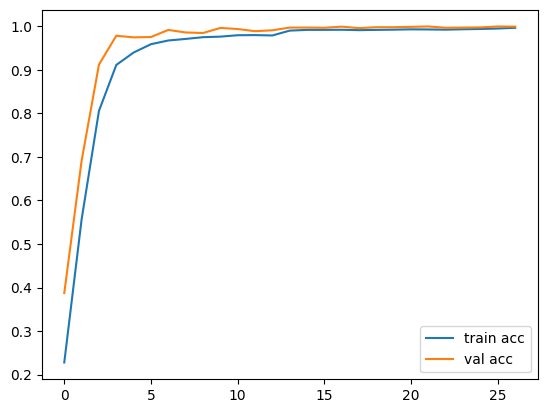

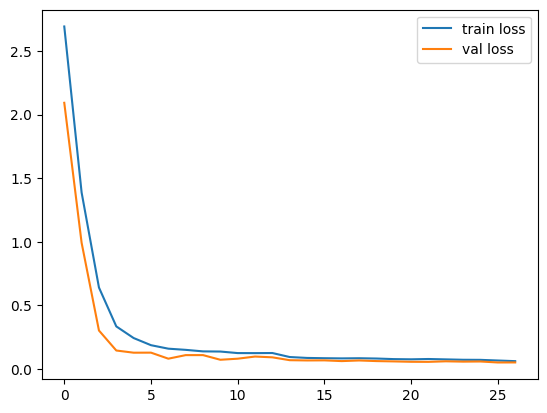

In [10]:
# CNN
plot_training_accuracy(history_model_cnn)
plot_training_loss(history_model_cnn)

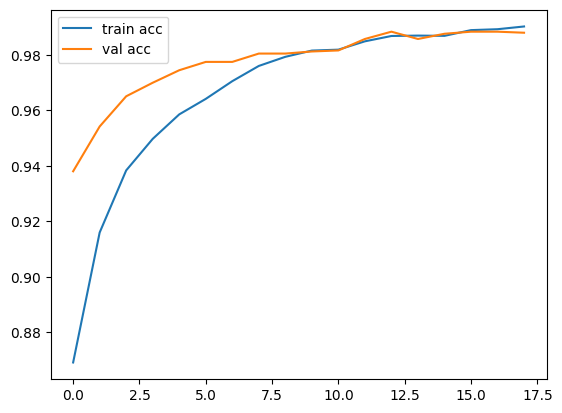

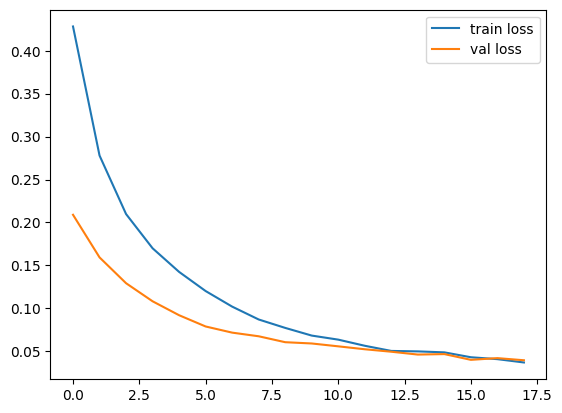

In [9]:
# Efficient Net V2
plot_training_accuracy(history_model_efficient_net)
plot_training_loss(history_model_efficient_net)

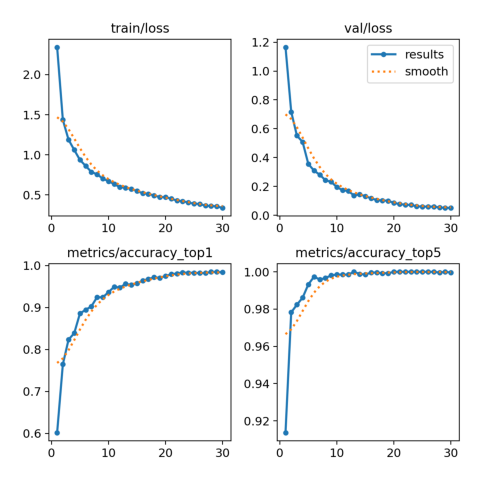

In [16]:
# YOLO
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('./runs/classify/train/results.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis('off')
plt.show()

## D. Conclusão

O presente estudo permitiu avaliar a hipótese de que técnicas de Deep Learning são eficazes para a tarefa de detecção e classificação de sinalização de trânsito. Os resultados obtidos confirmaram essa hipótese, uma vez que os modelos implementados — desde arquiteturas mais simples, como MLP, até abordagens avançadas baseadas em transfer learning (EfficientNetV2) e modelos otimizados (YOLO) — alcançaram bons índices de acurácia, recall e F1-score. Isso demonstra que redes neurais profundas conseguem extrair representações robustas das imagens e lidar com a variabilidade presente na base de dados.

Além disso, foi possível observar que o uso de técnicas de regularização (como Dropout, Early Stopping e L2) e estratégias de fine-tuning contribuiu significativamente para mitigar problemas de overfitting, aumentando a capacidade de generalização dos modelos. Também se verificou que modelos pré-treinados em grandes bases, como ImageNet e YOLO, embora possam ampliar a qualidade das detecções, nem sempre serão melhores que modelos mais simples.

Como trabalhos futuros, sugere-se expandir a investigação para cenários mais próximos da aplicação prática, como a detecção em vídeos em tempo real e em condições adversas (clima, iluminação e oclusões). Outra frente promissora é a utilização de arquiteturas mais recentes, como Vision Transformers (ViTs) (Dosovitskiy, 2021), que têm se mostrado competitivas em diversas tarefas de visão computacional. Por fim, a integração desses modelos em sistemas de veículos autônomos representaria um passo importante para validar a aplicabilidade dos resultados em ambientes reais.

## Referências bibliográficas

Abadi, M., Agarwal, A., Barham, P., Brevdo, E., Chen, Z., Citro, C., … & Zheng, X. (2016). TensorFlow: Large-scale machine learning on heterogeneous distributed systems. https://doi.org/10.48550/arXiv.1603.04467

Arcos-García, Á., Alvarez-García, J. A., & Soria-Morillo, L. M. (2018). Deep neural networks for traffic sign recognition systems: An analysis of spatial transformers and stochastic optimisation methods. Neural Networks, 99, 158–165. https://doi.org/10.1016/j.neunet.2018.01.005

Britannica. (2025). Karl Benz. Encyclopedia Britannica. https://www.britannica.com/biography/Karl-Benz

Clark, L. (2019). Traffic signals: A brief history. Washington State Magazine. https://magazine.wsu.edu/web-extra/traffic-signals-a-brief-history

Cleveland Police Museum. (2023). Early Electric Traffic Signals in Cleveland. Cleveland Police Historical Society & Museum. https://www.clevelandpolicemuseum.org/historical/early-electric-traffic-signals

Chollet, F.. (2015). Keras. GitHub repository. https://keras.io

Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., … Houlsby, N. (2021). An image is worth 16x16 words: Transformers for image recognition at scale. In International Conference on Learning Representations (ICLR). https://arxiv.org/abs/2010.11929

Mogelmose, A., Trivedi, M. M., & Moeslund, T. B. (2012). Vision-based traffic sign detection and analysis for intelligent driver assistance systems: Perspectives and survey. IEEE Transactions on Intelligent Transportation Systems, 13(4), 1484–1497. https://doi.org/10.1109/TITS.2012.2209421

Stallkamp, J., Schlipsing, M., Salmen, J., & Igel, C. (2011). The German Traffic Sign Recognition Benchmark: A multi-class classification competition. Proceedings of the IEEE International Joint Conference on Neural Networks (IJCNN), 1453–1460. https://gyao96.github.io/Elliptical-Traffic-Sign-Recognition/Ref/06033395.pdf

Tan, M., & Le, Q. V. (2021). EfficientNetV2: Smaller Models and Faster Training. Proceedings of the 38th International Conference on Machine Learning (ICML). https://doi.org/10.48550/arXiv.2104.00298

United Nations Economic Commission for Europe (UNECE). (1968). Convention on Road Signs and Signals. Vienna: United Nations. https://unece.org/texts-and-status-0

United Nations Economic Commission for Europe (UNECE). (2022). Historical background of the Conventions related to road traffic and traffic safety (Presentation 5). UNECE. https://unece.org/sites/default/files/2022-09/Presentation%205.pdf

Wong, A., Famouri, M., Shafiee, M. J., Li, F., & Chwyl, B. (2019). YOLO Nano: a Highly Compact You Only Look Once Convolutional Neural Network for Object Detection. https://doi.org/10.48550/arXiv.1910.01271

Zhao, J., Wu, Y., Deng, R., Xu, S., Gao, J., & Burke, A. (2025). A Survey of Autonomous Driving from a Deep Learning Perspective. ACM Comput. Surv. 57, 10, Article 263, 60 pages. https://doi.org/10.1145/3729420

Zhu, Z., Liang, D., Zhang, S., Huang, X., Li, B., & Hu, S. (2016). Traffic-sign detection and classification in the wild. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2110–2118. DOI: 10.1109/CVPR.2016.232. https://doi.org/10.1109/CVPR.2016.232
